In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### 1. Чтение и подготовка данных

In [2]:
TRAIN_SIZE = 50
TEST_SIZE = 50
ZERO_NEW_CASES_FILL = 1
START_DATE = '2020-03-03'

In [3]:
data_df = pd.read_csv(os.path.join('data', 'owid-covid-data.csv'), usecols=['date', 'total_cases', 'new_cases'])
data_df.date = data_df.date.map(datetime.fromisoformat)
data_df.new_cases = data_df.new_cases.mask(data_df.new_cases == 0, ZERO_NEW_CASES_FILL)
data_df = data_df[data_df.date >= datetime.fromisoformat(START_DATE)]
data_df.reset_index(drop=True, inplace=True)
data_df['log_new_cases'] = np.log(data_df.new_cases)
data_df['log_total_cases'] = np.log(data_df.total_cases)
data_df

,date,total_cases,new_cases,log_new_cases,log_total_cases
0,2020-03-03,5.0,1.0,0.000000,1.609438
1,2020-03-04,5.0,1.0,0.000000,1.609438
2,2020-03-05,5.0,1.0,0.000000,1.609438
3,2020-03-06,5.0,1.0,0.000000,1.609438
4,2020-03-07,8.0,3.0,1.098612,2.079442
...,...,...,...,...,...
163557,2022-02-26,235803.0,336.0,5.817111,12.370752
163558,2022-02-27,235803.0,1.0,0.000000,12.370752
163559,2022-02-28,236380.0,577.0,6.357842,12.373196
163560,2022-03-01,236871.0,491.0,6.196444,12.375271


Train test split

In [4]:
train_df = data_df[data_df.index < TRAIN_SIZE]
test_df = data_df[(data_df.index >= TRAIN_SIZE) & (data_df.index < (TEST_SIZE + TRAIN_SIZE))].dropna()

print(f'Train size: {train_df.shape[0]}')
print(f'Test size: {test_df.shape[0]}')

Train size: 50
Test size: 50


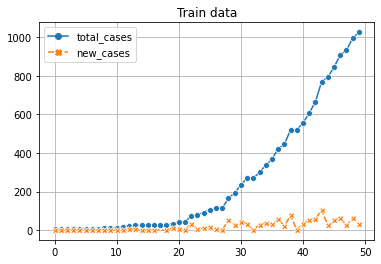

In [5]:
sns.lineplot(
    data=train_df.loc[:, ['total_cases', 'new_cases']],
    markers=True
)
plt.title('Train data')
plt.grid()
plt.show()

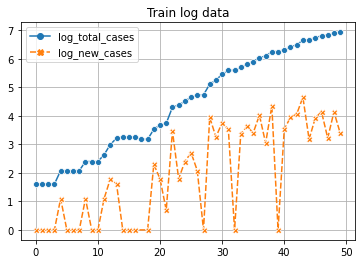

In [6]:
sns.lineplot(
    data=train_df.loc[:, ['log_total_cases', 'log_new_cases']],
    markers=True
)
plt.title('Train log data')
plt.grid()
plt.show()

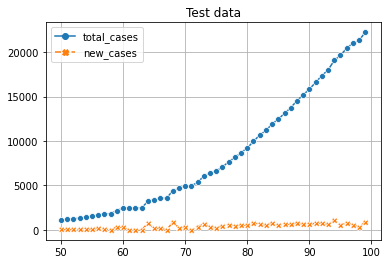

In [7]:
sns.lineplot(
    data=test_df.loc[:, ['total_cases', 'new_cases']],
    markers=True
)
plt.title('Test data')
plt.grid()
plt.show()

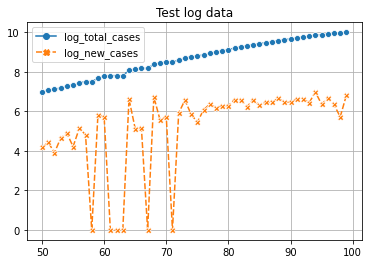

In [8]:
sns.lineplot(
    data=test_df.loc[:, ['log_total_cases', 'log_new_cases']],
    markers=True
)
plt.title('Test log data')
plt.grid()
plt.show()

### 2. Экспоненциальная модель

#### a. Модель с экспоненциальным ростом числа заболевших

In [9]:
class ExpModel(BaseEstimator):
    
    def __init__(self) -> None:
        self.lin_reg = LinearRegression()
        self.scaler = StandardScaler()
        
    def fit(self, X: np.array, y: np.array) -> None:
        X = self.scaler.fit_transform(X)
        self.lin_reg.fit(X=X, y=np.log(y))
        
    def predict_log(self, X: np.array) -> None:
        X = self.scaler.transform(X)
        prediction = self.lin_reg.predict(X)
        
        return prediction
        
    def predict(self, X: np.array) -> np.array:
        prediction = self.predict_log(X)
        prediction = np.exp(prediction)
        
        return prediction

In [10]:
model = ExpModel()
model.fit(
    X=train_df.index.to_numpy().reshape(-1, 1),
    y=train_df.total_cases.to_numpy()
)

In [11]:
test_df['prediction'] = model.predict(test_df.index.to_numpy().reshape(-1, 1))
test_df['log_prediction'] = model.predict_log(test_df.index.to_numpy().reshape(-1, 1))

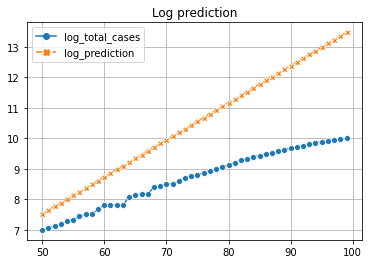

In [12]:
sns.lineplot(
    data=test_df.loc[:, ['log_total_cases', 'log_prediction']],
    markers=True
)
plt.title('Log prediction')
plt.grid()
plt.show()

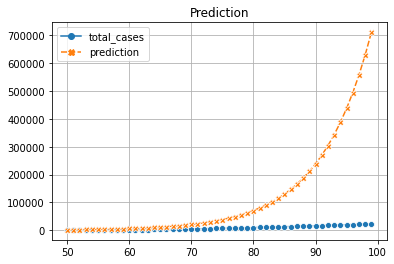

In [13]:
sns.lineplot(
    data=test_df.loc[:, ['total_cases', 'prediction']],
    markers=True
)
plt.title('Prediction')
plt.grid()
plt.show()

In [14]:
log_mse = mean_squared_error(test_df.log_total_cases, test_df.log_prediction)
exp_mse = mean_squared_error(test_df.total_cases, test_df.prediction)

print(f'Log MSE: {log_mse}')
print(f'MSE: {exp_mse}')

Log MSE: 3.999753469576587
MSE: 42778945062.88528


#### b. Поиск апостериорного распределения

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).